Oil Production Forecast with LSTM
-------------------------------------------------------

### Import required libraries

In [1]:
import os
import glob
RAND_SEED = 12345
import numpy as np
np.random.seed(RAND_SEED)
import tensorflow as tf
tf.random.set_seed(RAND_SEED)
import random
random.seed(RAND_SEED)
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

### Import and visualize Oil production data

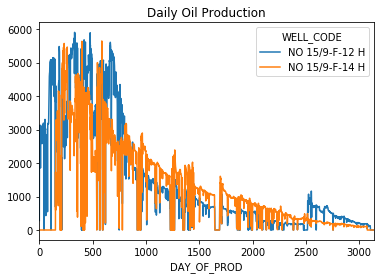

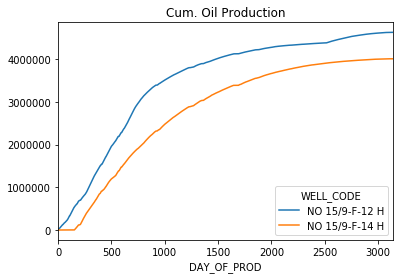

In [2]:
df = pd.read_csv('./Data/Volve_Oil_Production.csv')
well_codes = df.WELL_CODE.unique()
df = df.pivot(index='DAY_OF_PROD', columns='WELL_CODE', values=['OIL_PROD_VOL', 'CUM_OIL_PROD'])
df.plot(y='OIL_PROD_VOL', title='Daily Oil Production')
df.plot(y='CUM_OIL_PROD', title='Cum. Oil Production')

### Create input data for LSTM training and testing

In [3]:
train_oil_prod = df['CUM_OIL_PROD', well_codes[0]].values
test_oil_prod = df['CUM_OIL_PROD', well_codes[1]].values
LOOKBACK = 14

def prepare_lstm_input(prod_data, lookback, scaler=None):
    data = np.array(prod_data).reshape(-1, 1)
    if scaler == None:
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)
    else:
        data = scaler.transform(data)
    X = []
    y = []
    num_idxs = len(data)
    for i in range(lookback, num_idxs):
        i_start = i - lookback
        i_end = i - 1
        X.append([data[i] for i in range(i_start, i_end + 1)])
        y.append(data[i])
    num_y = len(y)
    X = np.array(X).reshape(num_y, lookback, 1)
    y = np.array(y).reshape(-1, 1)
    return X, y, scaler

X_train, y_train, scaler = prepare_lstm_input(train_oil_prod, LOOKBACK)
X_test, y_test, _ = prepare_lstm_input(test_oil_prod, LOOKBACK, scaler)

### Build and train LSTM model

In [4]:
NUM_HIDDEN = 28
VALID_FRAC = 0.1
BATCH_SIZE = 32
# Define a LSTM model
model = Sequential()
model.add(LSTM(NUM_HIDDEN, activation="relu", return_sequences=True, input_shape=(LOOKBACK, 1)))
model.add(LSTM(NUM_HIDDEN, activation="relu", return_sequences=False))
model.add(Dense(NUM_HIDDEN))
model.add(Dense(1))
model.compile(optimizer='Adadelta', loss="mse")
# Early-stopping callback
earlystop_callback = EarlyStopping(
    monitor='val_loss', min_delta=0.0001,
    patience=50)
# Save the best model
ckpt_path = './models/lstm.h5'
ckpt_callback = ModelCheckpoint(filepath=ckpt_path, mode='min', 
                                monitor='val_loss', verbose=1, 
                                save_best_only=True)
# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=BATCH_SIZE, 
                    validation_split=VALID_FRAC, 
                    callbacks=[earlystop_callback, ckpt_callback], 
                    verbose=1)

Train on 2814 samples, validate on 313 samples
Epoch 1/500
2720/2814 [===========================>..] - ETA: 0s - loss: 0.6026
Epoch 00001: val_loss improved from inf to 0.97707, saving model to ./models/lstm.h5
2814/2814 [==============================] - 3s 1ms/sample - loss: 0.6019 - val_loss: 0.9771
Epoch 2/500
2720/2814 [===========================>..] - ETA: 0s - loss: 0.5992
Epoch 00002: val_loss improved from 0.97707 to 0.97113, saving model to ./models/lstm.h5
2814/2814 [==============================] - 1s 425us/sample - loss: 0.5980 - val_loss: 0.9711
Epoch 3/500
2688/2814 [===========================>..] - ETA: 0s - loss: 0.5952
Epoch 00003: val_loss improved from 0.97113 to 0.96485, saving model to ./models/lstm.h5
2814/2814 [==============================] - 1s 432us/sample - loss: 0.5938 - val_loss: 0.9649
Epoch 4/500
2656/2814 [===========================>..] - ETA: 0s - loss: 0.5884
Epoch 00004: val_loss improved from 0.96485 to 0.95824, saving model to ./models/lstm.h

### Review the model training

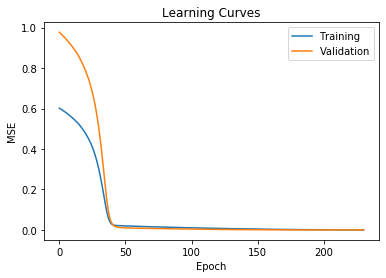

In [5]:
# Plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.show()

### Use saved model to predict test data

Text(0, 0.5, 'Predicted')

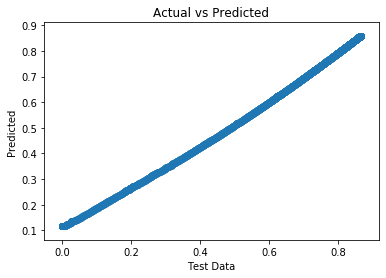

In [6]:
# Make predictions with the best model using test data
model = load_model(ckpt_path)
y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred)
plt.title('Actual vs Predicted')
plt.xlabel('Test Data')
plt.ylabel('Predicted')

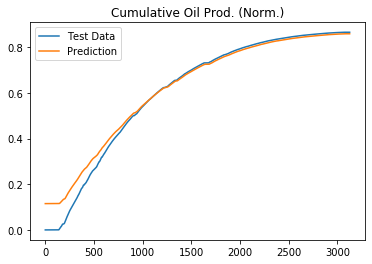

In [7]:
plt.title('Cumulative Oil Prod. (Norm.)')
plt.plot(y_test, label='Test Data')
plt.plot(y_pred, label='Prediction')
plt.legend(loc="best")

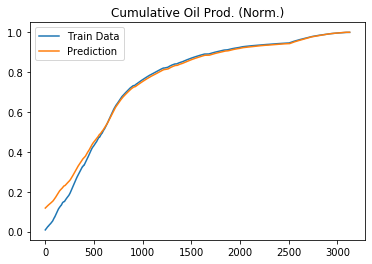

In [8]:
y_pred_train = model.predict(X_train)
plt.title('Cumulative Oil Prod. (Norm.)')
plt.plot(y_train, label='Train Data')
plt.plot(y_pred_train, label='Prediction')
plt.legend(loc="best")